In [1]:
!pip install hazm

In [2]:
import logging
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
import pandas as pd
from hazm import word_tokenize
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df=pd.read_csv("/content/drive/MyDrive/Spell_correction/data.csv")


In [5]:
# df=df[df["main_category"]=="Main signs" ]

In [6]:
df=df[["wrong_sentence","correct_sentence"]]
df=df.dropna()

In [7]:
len(df)

9205

In [8]:
df.head()

,wrong_sentence,correct_sentence
0,افغانستان\n \n موضوع : اسراف\n \n اسراف را خدا...,افغانستان\n \n موضوع : اسراف\n \n اسراف را خدا...
1,افغانستان\n \n موضوع : اسراف\n \n اسراف را خدا...,افغانستان\n \n موضوع : اسراف\n \n اسراف را خدا...
2,افغانستان\n \n موضوع : اسراف\n \n اسراف را خدا...,افغانستان\n \n موضوع : اسراف\n \n اسراف را خدا...
3,افغانستان\n \n موضوع : اسراف\n \n اسراف را خدا...,افغانستان\n \n موضوع : اسراف\n \n اسراف را خدا...
4,افغانستان\n \n موضوع : اسراف\n \n اسراف را خدا...,افغانستان\n \n موضوع : اسراف\n \n اسراف را خدا...


In [9]:
#create vocabulay
symbols_to_remove = ['@', '#', '$', '%', '^', '&', '*', '(', ')','[',']','{','}','"','*\r','+',',','ø','>>','CV','EXPO','None','alfare','fat','«','0-9','\\u200','\\u200c','\\u200f','\\u200e']
# Create a regex pattern that matches any of the symbols in the list
pattern = re.compile(f"[{re.escape(''.join(symbols_to_remove))}]")

In [10]:
# create a dictionary to convert the vocabulary to integers
vocab_to_int = {}
count = 0
#tokenize and put <start> , < end >
# Add special tokens to vocab_to_int
codes = ['<PAD>','<eos>','<sos>','<UNK>']
for code in codes:
    vocab_to_int[code] = count
    count += 1

for index in df.index:
    for word in word_tokenize(df.at[index,"wrong_sentence"]):
        cleaned_string = pattern.sub("", word)
        # cleaned_string = new_word.replace("\u200c", "").replace("\u200f", "")
        if cleaned_string not in vocab_to_int:
            vocab_to_int[cleaned_string] = count
            count += 1
    for word in word_tokenize(df.at[index,"correct_sentence"]):
        cleaned_string = pattern.sub("", word)
        # cleaned_string = new_word.replace("\u200c", "").replace("\u200f", "")
        if cleaned_string not in vocab_to_int:
            vocab_to_int[cleaned_string] = count
            count += 1

In [11]:
vocab_size = len(vocab_to_int)
print("The vocabulary contains {} words.".format(vocab_size))

The vocabulary contains 9686 words.


In [12]:
# Create another dictionary to convert integers to their respective characters
int_to_vocab = {}
for word, value in vocab_to_int.items():
    int_to_vocab[value] = word

In [13]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    df['correct_sentence'], target_vocab_size=len(vocab_to_int))

In [14]:
# Example text
text = "زبان فارسی زیبا است."

# Encode the text
encoded = tokenizer.encode(text)
print("Encoded:", encoded)

# Decode the subwords back to the original text
decoded = tokenizer.decode(encoded)
print("Decoded:", decoded)

Encoded: [196, 371, 527, 16, 10015]
Decoded: زبان فارسی زیبا است.


In [15]:
#change input to tokens_id
def tokenizer(sentence):
    tmp=[]
    tmp.append(vocab_to_int["<sos>"])
    for word in word_tokenize(sentence):
        cleaned_string = pattern.sub("", word)
        if cleaned_string not in vocab_to_int:
            tmp.append(vocab_to_int["<UNK>"])
        else:
          tmp.append(vocab_to_int[cleaned_string])
    tmp.append(vocab_to_int["<eos>"])
    # padded_sequences = tf.keras.preprocessing.sequence.pad_sequences([tmp],maxlen=512 ,padding='post', value=vocab_to_int["<PAD>"])
    return tmp



In [16]:
def detokenizer(tokens):
    tmp=""
    for token in tokens:
        tmp+=int_to_vocab[token]+" "
    return tmp

In [17]:
lengths = []

for ind in df.index:
  wr_tokens = tokenizer(df.at[ind,"wrong_sentence"])
  lengths.append(len(wr_tokens))
  cor_tokens = tokenizer(df.at[ind,"correct_sentence"])
  lengths.append(len(cor_tokens))

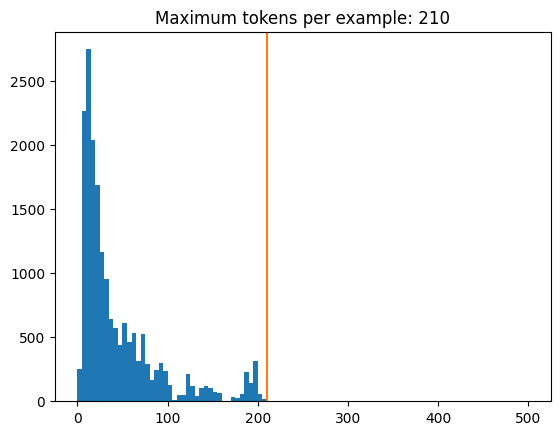

In [18]:

plt.hist(lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

In [19]:
wrong_sentence=[]
correct_sentence_inputs=[]
correct_sentence_labels=[]
# MAX_TOKENS=256
for ind in df.index:
  wrong=tokenizer(df.at[ind,"wrong_sentence"])
  # wrong=wrong[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
  wrong_sentence.append(tf.keras.preprocessing.sequence.pad_sequences([wrong],maxlen=256 ,padding='post', value=vocab_to_int["<PAD>"],truncating='post')
)
  correct_inputs=tokenizer(df.at[ind,"correct_sentence"])
  # correct_sentence = correct_inputs[:, :(MAX_TOKENS+1)]
  correct_sentence_inputs_one = correct_inputs[:-1]     #drop <eos>
  correct_sentence_labels_one=correct_inputs[1:]        #drop <sos>
  correct_sentence_inputs .append(tf.keras.preprocessing.sequence.pad_sequences([correct_sentence_inputs_one],maxlen=256 ,padding='post', value=vocab_to_int["<PAD>"],truncating='post') )
  correct_sentence_labels .append(tf.keras.preprocessing.sequence.pad_sequences([correct_sentence_labels_one],maxlen=256 ,padding='post', value=vocab_to_int["<PAD>"],truncating='post') )


In [20]:
x=tokenizer(df.at[2,"correct_sentence"])

In [21]:
print(len(x))
x=x[:-1]
print(len(x))
print(x)

190
189
[2, 4, 5, 6, 7, 7, 8, 9, 10, 11, 12, 13, 14, 15, 7, 16, 17, 7, 18, 8, 10, 11, 19, 20, 21, 22, 23, 19, 24, 25, 26, 27, 26, 28, 29, 7, 30, 19, 31, 32, 11, 33, 34, 19, 35, 33, 23, 36, 37, 38, 39, 25, 26, 27, 26, 40, 41, 42, 43, 44, 24, 39, 45, 46, 47, 48, 33, 49, 9, 50, 51, 22, 16, 19, 48, 33, 49, 17, 52, 22, 16, 14, 12, 13, 53, 54, 55, 56, 16, 90, 12, 13, 57, 54, 55, 58, 56, 16, 59, 60, 29, 61, 12, 13, 62, 63, 64, 59, 60, 8, 33, 65, 66, 55, 63, 16, 67, 68, 61, 67, 69, 61, 67, 70, 61, 67, 71, 61, 53, 59, 60, 29, 61, 7, 72, 73, 8, 33, 65, 74, 75, 76, 77, 7, 78, 79, 19, 7, 10, 80, 59, 60, 33, 65, 81, 56, 82, 24, 7, 78, 79, 83, 54, 84, 33, 35, 22, 85, 19, 7, 78, 16, 73, 29, 61, 7, 78, 79, 73, 29, 54, 84, 86, 54, 87, 22, 85, 88, 89]


In [22]:
df=pd.DataFrame({
    "wrong_sentence":wrong_sentence,
    "correct_sentence_inputs":correct_sentence_inputs,
    "correct_sentence_labels":correct_sentence_labels
})

In [23]:
df.head()

,wrong_sentence,correct_sentence_inputs,correct_sentence_labels
0,"[[2, 4, 5, 6, 7, 7, 8, 9, 10, 11, 12, 13, 14, ...","[[2, 4, 5, 6, 7, 7, 8, 9, 10, 11, 12, 13, 14, ...","[[4, 5, 6, 7, 7, 8, 9, 10, 11, 12, 13, 14, 15,..."
1,"[[2, 4, 5, 6, 7, 7, 8, 9, 10, 11, 12, 13, 14, ...","[[2, 4, 5, 6, 7, 7, 8, 9, 10, 11, 12, 13, 14, ...","[[4, 5, 6, 7, 7, 8, 9, 10, 11, 12, 13, 14, 15,..."
2,"[[2, 4, 5, 6, 7, 7, 8, 9, 10, 11, 12, 13, 14, ...","[[2, 4, 5, 6, 7, 7, 8, 9, 10, 11, 12, 13, 14, ...","[[4, 5, 6, 7, 7, 8, 9, 10, 11, 12, 13, 14, 15,..."
3,"[[2, 4, 5, 6, 7, 7, 8, 9, 10, 11, 12, 13, 14, ...","[[2, 4, 5, 6, 7, 7, 8, 9, 10, 11, 12, 13, 14, ...","[[4, 5, 6, 7, 7, 8, 9, 10, 11, 12, 13, 14, 15,..."
4,"[[2, 4, 5, 6, 7, 7, 8, 9, 10, 11, 12, 13, 14, ...","[[2, 4, 5, 6, 7, 7, 8, 9, 10, 11, 12, 13, 14, ...","[[4, 5, 6, 7, 7, 8, 9, 10, 11, 12, 13, 14, 15,..."


In [24]:
train,test=train_test_split(df,test_size=0.2,random_state=24)

In [25]:
correct_label=tf.convert_to_tensor(train['correct_sentence_labels'].tolist(), dtype=tf.int64)
wrong=tf.convert_to_tensor(train['wrong_sentence'].tolist(), dtype=tf.int64)
correct_inputs=tf.convert_to_tensor(train['correct_sentence_inputs'].tolist(), dtype=tf.int64)



correct_label_test=tf.convert_to_tensor(test['correct_sentence_labels'].tolist(), dtype=tf.int64)
wrong_test=tf.convert_to_tensor(test['wrong_sentence'].tolist(), dtype=tf.int64)
correct_inputs_test=tf.convert_to_tensor(test['correct_sentence_inputs'].tolist(), dtype=tf.int64)



In [26]:
correct_label=tf.squeeze(correct_label, axis=1)
wrong=tf.squeeze(wrong, axis=1)
correct_inputs=tf.squeeze(correct_inputs, axis=1)

correct_label_test=tf.squeeze(correct_label_test, axis=1)
wrong_test=tf.squeeze(wrong_test, axis=1)
correct_inputs_test=tf.squeeze(correct_inputs_test, axis=1)


In [27]:

tensor_dict = (
     wrong,
     correct_inputs)
tensor_dict_test = (
     wrong_test,
     correct_inputs_test
)

In [28]:
dataset_train = tf.data.Dataset.from_tensor_slices((tensor_dict,correct_label))
dataset_test = tf.data.Dataset.from_tensor_slices((tensor_dict_test,correct_label_test))

In [29]:
# dataset


In [30]:
for (wrong,correct_inputs) ,label in dataset_train.take(1):
    print(wrong)
    print(correct_inputs)
    print(label)

tf.Tensor(
[   2  320   77  531 1475 5373 5374 5375 5376 5377 5378  226   77 2153
  226  404 5379 5380 5381  119 2120   57 4165  119 2156 5367 5382  119
 2120 5367  177  256  119   57 2120  231 5383  177 1230   33  558 5384
 1551  119  566  183   53 2124  131 5383   33 5367   22  584   89    1
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

In [31]:

MAX_TOKENS=256
def prepare_batch(wrong_sentence,correct_sentence):
    wrong_sentence = tokenizer(wrong_sentence)      # Output is ragged.
    wrong_sentence = wrong_sentence[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    print(wrong_sentence)
    wrong_sentence = wrong_sentence.to_tensor()  # Convert to 0-padded dense Tensor

    correct_sentence = tokenizer(correct_sentence)
    correct_sentence = correct_sentence[:, :(MAX_TOKENS+1)]
    correct_sentence_inputs = correct_sentence[:, :-1].to_tensor()  # Drop the [END] tokens
    correct_sentence_labels = correct_sentence[:, 1:].to_tensor()   # Drop the [START] tokens

    return (wrong_sentence, correct_sentence_inputs), correct_sentence_labels

In [32]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [33]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE))
      # .map(prepare_batch, tf.data.AUTOTUNE)
      # .prefetch(buffer_size=tf.data.AUTOTUNE))

In [34]:
# Create training and validation set batches.
train_batches = make_batches(dataset_train)
val_batches = make_batches(dataset_test)

In [35]:
# for x,c in train_batches.take(1):
#   print(x)
#   print(c)

In [36]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)


In [37]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [38]:
for (wrong_sentence,correct_sentence), correct_sentence_labels in train_batches.take(1):
  break
print(wrong_sentence.shape)
print(correct_sentence.shape)
print(correct_sentence_labels.shape)
print(tf.shape(wrong_sentence))

(64, 256)
(64, 256)
(64, 256)
tf.Tensor([ 64 256], shape=(2,), dtype=int32)


In [39]:
# print(wrong_sentence[0][:10])
# print(correct_sentence_labels[0][:10])

In [40]:
embed_wrong = PositionalEmbedding(vocab_size=len(vocab_to_int), d_model=512)
embed_correct = PositionalEmbedding(vocab_size=len(vocab_to_int), d_model=512)

wrong_emb = embed_wrong(wrong_sentence)
correct_emb = embed_correct(correct_sentence)
print(wrong_emb.shape)

(64, 256, 512)


In [41]:
# correct_emb._keras_mask

In [42]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()


In [43]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [44]:
# sample_ca = CrossAttention(num_heads=2, key_dim=512)

# print(wrong_emb.shape)
# print(correct_emb.shape)
# print(sample_ca(correct_emb, wrong_emb).shape)

In [45]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [46]:
# sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

# print(wrong_emb.shape)
# print(sample_gsa(wrong_emb).shape)

In [47]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [48]:
# sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

# print(correct_emb.shape)
# print(sample_csa(correct_emb).shape)

In [49]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

In [50]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [51]:
# sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

# print(wrong_emb.shape)
# print(sample_encoder_layer(wrong_emb).shape)

In [52]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.


In [53]:
# sample_encoder = Encoder(num_layers=4,
#                          d_model=512,
#                          num_heads=8,
#                          dff=2048,
#                          vocab_size=len(vocab_to_int))

# sample_encoder_output = sample_encoder(wrong_sentence, training=False)

# # Print the shape.
# print(wrong_sentence.shape)
# print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

In [54]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [55]:
# sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

# sample_decoder_layer_output = sample_decoder_layer(
#     x=correct_emb, context=wrong_emb)

# print(correct_emb.shape)
# print(wrong_emb.shape)
# print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

In [56]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [57]:
# # Instantiate the decoder.
# sample_decoder = Decoder(num_layers=4,
#                          d_model=512,
#                          num_heads=8,
#                          dff=2048,
#                          vocab_size=len(vocab_to_int))

# output = sample_decoder(
#     x=correct_sentence,
#     context=wrong_emb)

# # Print the shapes.
# print(correct_sentence.shape)
# print(wrong_emb.shape)
# print(output.shape)

In [58]:
# sample_decoder.last_attn_scores.shape  # (batch, heads, target_seq, input_seq)

In [59]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

In [60]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [61]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=len(vocab_to_int),
    target_vocab_size=len(vocab_to_int),
    dropout_rate=dropout_rate)

In [62]:
# output = transformer((wrong_sentence, correct_sentence))

# print(correct_sentence.shape)
# print(wrong_sentence.shape)
# print(output.shape)

In [63]:
# attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
# print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

In [64]:
# transformer.summary()

In [65]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=len(vocab_to_int),
    target_vocab_size=len(vocab_to_int),
    dropout_rate=dropout_rate)

In [66]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [67]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

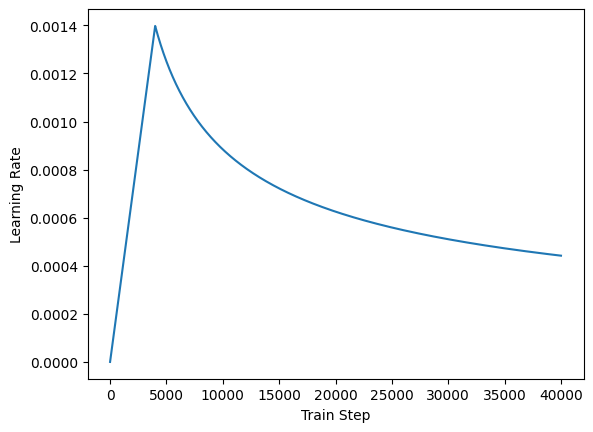

In [68]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [69]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


In [70]:
def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)


In [71]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [72]:
transformer.fit(train_batches,
                epochs=30,
                validation_data=val_batches)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/ke

116/116 ━━━━━━━━━━━━━━━━━━━━ 160s 887ms/step - loss: 9.1202 - masked_accuracy: 0.0107 - val_loss: 8.7358 - val_masked_accuracy: 0.0445
Epoch 2/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 75s 646ms/step - loss: 8.5376 - masked_accuracy: 0.0524 - val_loss: 7.8297 - val_masked_accuracy: 0.0797
Epoch 3/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 71s 610ms/step - loss: 7.5711 - masked_accuracy: 0.0831 - val_loss: 6.8712 - val_masked_accuracy: 0.1262
Epoch 4/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 71s 610ms/step - loss: 6.6689 - masked_accuracy: 0.1410 - val_loss: 6.1632 - val_masked_accuracy: 0.1723
Epoch 5/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 71s 610ms/step - loss: 5.9369 - masked_accuracy: 0.1917 - val_loss: 5.2988 - val_masked_accuracy: 0.2437
Epoch 6/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 71s 613ms/step - loss: 5.0049 - masked_accuracy: 0.2775 - val_loss: 4.3198 - val_masked_accuracy: 0.3636
Epoch 7/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 86s 651ms/step - loss: 3.9707 - masked_accuracy: 0.4052 - val_loss: 3.4331 - val_masked_accuracy: 0.

In [73]:
class Spell_correction(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # print(sentence.shape)
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    # assert isinstance(sentence, tf.Tensor)
    # if len(sentence.shape) == 0:
    #   sentence = sentence[tf.newaxis]
    x=self.tokenizers(sentence)
    x_1=tf.keras.preprocessing.sequence.pad_sequences([x],maxlen=256 ,padding='post', value=vocab_to_int["<PAD>"],truncating='post')

    sentence =tf.convert_to_tensor( x_1,dtype=tf.int64)
    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    # start_end = self.tokenizers.en.tokenize([''])[0]
    # start = start_end[0][tf.newaxis]
    # end = start_end[1][tf.newaxis]

    list_temp=[]
    list_temp.append(vocab_to_int['<sos>'])
    start=tf.constant(list_temp,dtype=tf.int64)
    list_temp=[]
    list_temp.append(vocab_to_int['<eos>'])
    end=tf.constant(list_temp,dtype=tf.int64)
    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)
    # print(output_array.shape)
    for i in tf.range(max_length):

      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    # text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    # tokens = tokenizers.en.lookup(output)[0]
    text=detokenizer(output.numpy().tolist()[0])
    # Return the tokens
    tokens=[]
    for num in output.numpy().tolist()[0]:
      tokens.append(int_to_vocab[num])
    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text,tokens, attention_weights

In [74]:
def print_correction(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [75]:
spell_corrector = Spell_correction(tokenizer, transformer)

In [76]:
input= "مدرس ها شرو وشود و زیادی بچها در مدرسه سپت نام کرنند ."
ground_truth="مدرس ها شرو وشود و زیادی بچه ها در مدرسه سپت نام کرنند ."



translated_text, translated_tokens, attention_weights = spell_corrector(
    input)
print_correction(input, translated_text, ground_truth)

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Input:         : مدرس ها شرو وشود و زیادی بچها در مدرسه سپت نام کرنند .
Prediction     : <sos> مدرس ها شرو وشود و زیادی بچها در مدرسه سپت نام کرنند . <eos> 
Ground truth   : مدرس ها شرو وشود و زیادی بچه ها در مدرسه سپت نام کرنند .


In [77]:
tf.config.run_functions_eagerly(True)

In [78]:
class ExportSpellCorrector(tf.Module):
  def __init__(self, spell_corrector):
    self.spell_corrector = spell_corrector

  @tf.function
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.spell_corrector(sentence, max_length=MAX_TOKENS)

    return result

In [79]:
spell_corrector = ExportSpellCorrector(spell_corrector)

In [82]:
spell_corrector("دیوار کلاس سفد است.")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/ke

'<sos> دیوار کلاس سفید است . <eos> '

In [81]:
tf.saved_model.save(spell_corrector, export_dir='/content/drive/MyDrive/Spell_correction/saved_model/all')